# P5 Vehicle Detection

The outline of the twmplate / rubris is as follows: 
### Histogram of Oriented Gradients (HOG)
1. Explain how (and identify where in your code) you extracted HOG features from the training images.
    a. read in images, show examples of each 
    b. images for report
    c. exploring different color spaces
2. Explain final choice of HOG parameters
3. Describe and identify where in code, training a classifier using selected HOG features
    a. linear svm etc
    
### Sliding Window Approach
1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?
2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to try to minimize false positives and reliably detect cars?

### Video Implementation
1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

### Discussion
1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust



In [66]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
from skimage.feature import hog
from skimage import color, exposure
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time



In [67]:
# images are divided up into vehicles and non-vehicles
# this append the file paths of each image to separate lists 

images = glob.glob('/home/deep_cat/spc-P5/smallset/*.jpeg')
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
 

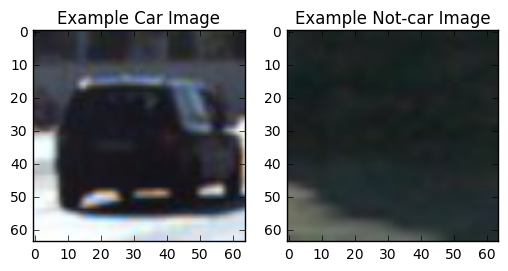

In [68]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Features
Two functions will generate two kinds oof features
1. bin_spatial
2. color_hist



In [69]:
image = mpimg.imread(cars[car_ind])

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel()
    # Return the feature vector
    return features

features = bin_spatial(image)

In [70]:
features

array([ 33,  39,  42, ..., 220, 232, 244], dtype=uint8)

In [71]:
len(features)

3072

In [72]:
32*32*3

3072

In [73]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

features = bin_spatial(image)
len(features)



3072

In [74]:
# Define a function to compute binned color features 
# spatial binning is just reducing the resolution 
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features


In [75]:

# Divide up into cars and notcars
images = glob.glob('/home/deep_cat/spc-P5/smallset/*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

orient = 9
pix_per_cell = 8
cell_per_block = 2

# these lines read in the images and at the same time perform all the computation to take 
# them in as feature vectors
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))


In [76]:
# so at this point these feature values are not normalized
# this stuffnormalizes the features
# Create an array stack of feature vectors

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [77]:
len(scaled_X)


2395

In [78]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [79]:
# this is the SVC classifier
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

0.6984462738037109 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.983298538622
0.0001590251922607422 Seconds to predict with SVC


# Sliding Windows

0


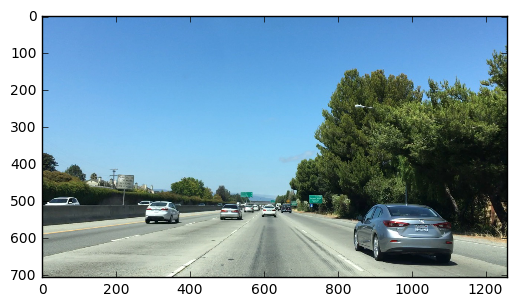

In [80]:
# Here is your draw_boxes function 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = mpimg.imread('bbox-example-image.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[500, 720], 
                    xy_window=(256, 256), xy_overlap=(0.5,0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
print(len(windows))

50
((400, 490), (432, 522))


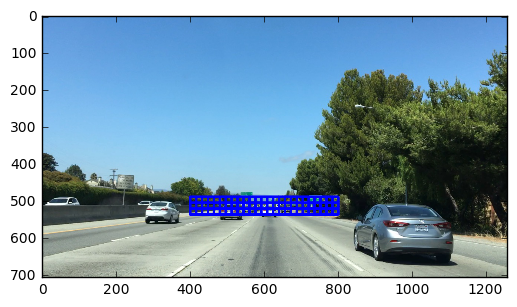

In [81]:
# redoing sliding windows 

# def multi_sliding_windows(img):
    
    # small windows at the horizon 
    
       # Compute the span of the region to be searched  
x_start_stop = (400, 800)
y_start_stop = (490, 540)
xy_overlap = (0.5,.5)
xy_window=(32, 32)

xspan = x_start_stop[1] - x_start_stop[0]
yspan = y_start_stop[1] - y_start_stop[0]

 # Compute the number of pixels per step in x/y
nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

 # Compute the number of windows in x/y
nx_windows = np.int(xspan/nx_pix_per_step) - 1
ny_windows = np.int(yspan/ny_pix_per_step) - 1

window_list = []

for ys in range(ny_windows):
    for xs in range(nx_windows):
       
        startx = xs*nx_pix_per_step + x_start_stop[0]
        endx = startx + xy_window[0]
        starty = ys*ny_pix_per_step + y_start_stop[0]
        endy = starty + xy_window[1]
      
        window_list.append(((startx, starty), (endx, endy)))
    
print (yspan)
print(window_list[0])

window_img = draw_boxes(image, window_list, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

170
28


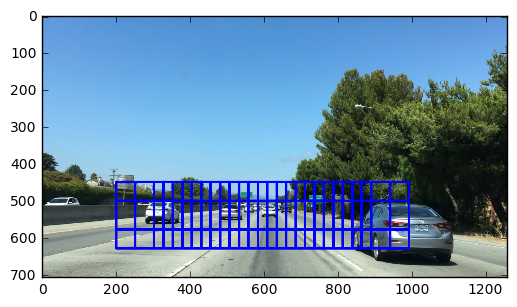

In [82]:
  # small windows at the horizon 
    
       # Compute the span of the region to be searched  
x_start_stop = (200, 1000)
y_start_stop = (450, 620)
xy_overlap = (0.6,0.6)
xy_window=(128, 128)

xspan = x_start_stop[1] - x_start_stop[0]
yspan = y_start_stop[1] - y_start_stop[0]

 # Compute the number of pixels per step in x/y
nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

 # Compute the number of windows in x/y
nx_windows = np.int(xspan/nx_pix_per_step) - 1
ny_windows = np.int(yspan/ny_pix_per_step) - 1

window_list = []

for ys in range(ny_windows):
    for xs in range(nx_windows):
       
        startx = xs*nx_pix_per_step + x_start_stop[0]
        endx = startx + xy_window[0]
        starty = ys*ny_pix_per_step + y_start_stop[0]
        endy = starty + xy_window[1]
      
        window_list.append(((startx, starty), (endx, endy)))
    
print (yspan)
# print(window_list[0])
print(len(window_list))
window_img = draw_boxes(image, window_list, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

270
[((0, 450), (300, 750)), ((120, 450), (420, 750)), ((240, 450), (540, 750)), ((360, 450), (660, 750)), ((480, 450), (780, 750)), ((600, 450), (900, 750)), ((720, 450), (1020, 750)), ((840, 450), (1140, 750)), ((960, 450), (1260, 750))]


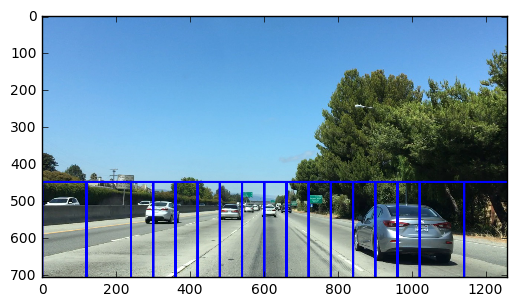

In [83]:
  # small windows at the horizon 
    
       # Compute the span of the region to be searched  
x_start_stop = (0, 1280)
y_start_stop = (450, 720)
xy_overlap = (0.6,0.6)
xy_window=(300, 300)

xspan = x_start_stop[1] - x_start_stop[0]
yspan = y_start_stop[1] - y_start_stop[0]

 # Compute the number of pixels per step in x/y
nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

 # Compute the number of windows in x/y
nx_windows = np.int(xspan/nx_pix_per_step) - 1
ny_windows = np.int(yspan/ny_pix_per_step) - 1

window_list = []

for ys in range(ny_windows):
    for xs in range(nx_windows):
       
        startx = xs*nx_pix_per_step + x_start_stop[0]
        endx = startx + xy_window[0]
        starty = ys*ny_pix_per_step + y_start_stop[0]
        endy = starty + xy_window[1]
      
        window_list.append(((startx, starty), (endx, endy)))
    
print (yspan)
# print(window_list[0])
print(window_list)
window_img = draw_boxes(image, window_list, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

# search and classify

In [84]:
# here is the classification function 
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        
        test_features =  scaler.transform(np.array(features))
        print(test_features)
#         .reshape(1, -1)
        #6) Predict using your classifier
#         prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

1

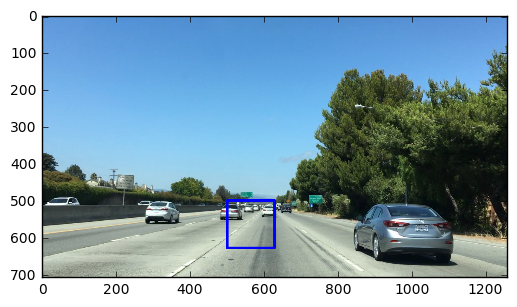

In [85]:
# inspecting the search windows function
img =image
windows = slide_window(image, x_start_stop=[500, 630], y_start_stop=[500, 630], 
                    xy_window=(128, 128), xy_overlap=(0.5,0.5))

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
len(windows)



# detections = 
# test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      

In [86]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [88]:
image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()






windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


/home/deep_cat/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


ValueError: operands could not be broadcast together with shapes (2580,) (4932,) (2580,) 